## Описание проекта

Представлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

In [46]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
from sklearn import preprocessing
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
import time
import sys
import gc
import pickle
import random
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
import lightgbm as lgb

Оглавление
---

##### Часть 1. Подготовка:
* [1.1. Загрузка данных.](#1-bullet)

##### Часть 2. Анализ:
* [2.1. Ресемплинг данных.](#2-bullet)
* [2.2. Скользящее среднее.](#3-bullet)
* [2.3. Создание признаков.](#4-bullet)

##### Часть 3. Обучение:
* [3.1. Линейная регрессия.](#5-bullet)

##### Часть 4. Тестирование:
* [4.1. Проверка линейной регрессии на тестовых данных.](#6-bullet)


# 1. Подготовка

__1.1. Загрузка данных__
Загрузим данные в переменную taxi, выведем на экран общую информацию.
<a id='1-bullet'></a>

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=['datetime'],parse_dates=['datetime'])
print('Общая информация о данных \n')
print(taxi.info())
# taxi=taxi.set_index('datetime')
taxi.sort_index(inplace=True)
print('\nКоличество заказов такси: \n',taxi.tail())
print(taxi.describe())

Общая информация о данных 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Количество заказов такси: 
                      num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


__Вывод__
На первом шаге мы создали столбец индексов из столбца datetime, предварительно переведя его в формат datetime64.
Данные в таблице отслеживаются каждые 10 секунд. Количество заказаов меняется от 0 до 119, но в среднем каждые 10 секунд приходят по 14 заказов.

# 2. Анализ

__2.1. Ресемплинг данных__
Проведем анализ данных заказов на монотонность. Целью проекта является предсказание данные на один час вперед, поэтому проведем ресемплинг данных.
<a id='2-bullet'></a>

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

Проверка списка значений на монотонность:  True


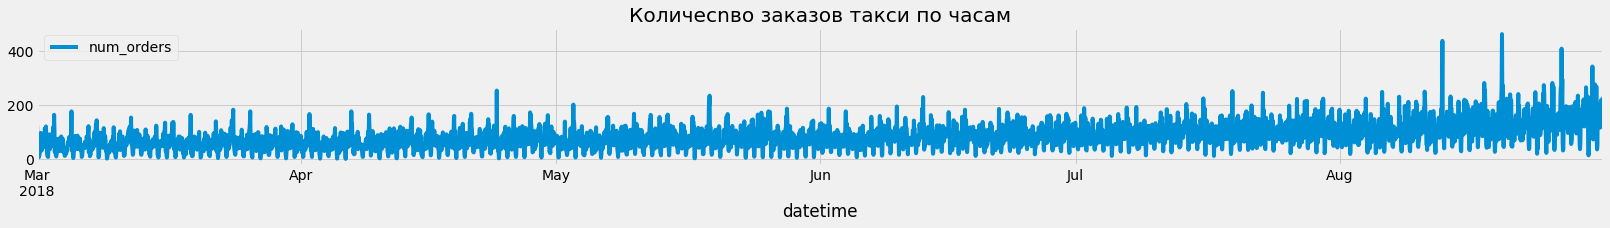

In [3]:
taxi_per_hour = taxi.resample('1H').sum()
print(taxi_per_hour.head())
print('\nПроверка списка значений на монотонность: ',taxi.index.is_monotonic)
plt.figure(figsize=(25, 8))
plt.subplot(311)
taxi_per_hour.plot(ax=plt.gca())
plt.title('Количеcnво заказов такси по часам')
plt.show()

__Вывод__
Данных слишком много, поэтом умы видим на графике только шум, из которого невозможно выделить сезонность и сделать какие-то выводы.
В графике присутствуют несколько выделяющихся значений в августе, однако сложно назвать их выбросами, так как они едва превышают 400 заказов.

__2.2. Скользящее среднее__
<a id='3-bullet'></a>

Text(0.5, 1.0, 'Количеcnво заказов такси по часам')

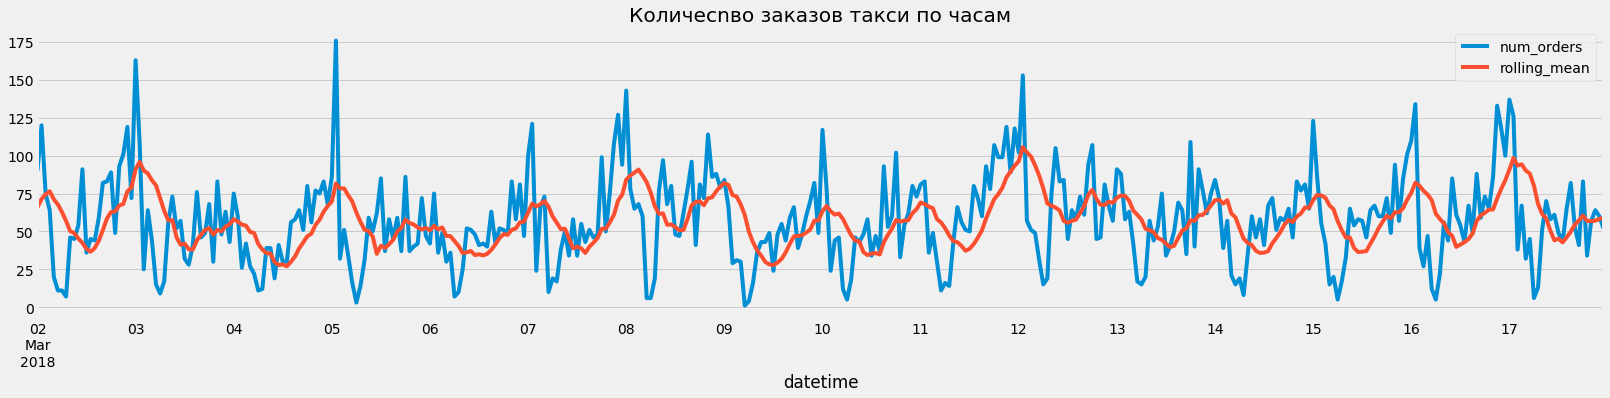

In [4]:
taxi_per_hour['rolling_mean'] = taxi_per_hour.rolling(10).mean()
taxi_per_hour.dropna(inplace=True)
plt.figure(figsize=(25, 17))
plt.subplot(311)
taxi_per_hour['2018-03-02':'2018-03-17'].plot(ax=plt.gca())
plt.title('Количеcnво заказов такси по часам')

__Вывод__
При применении скользящего среднего становится возможным графически определить некоторую сезонность.

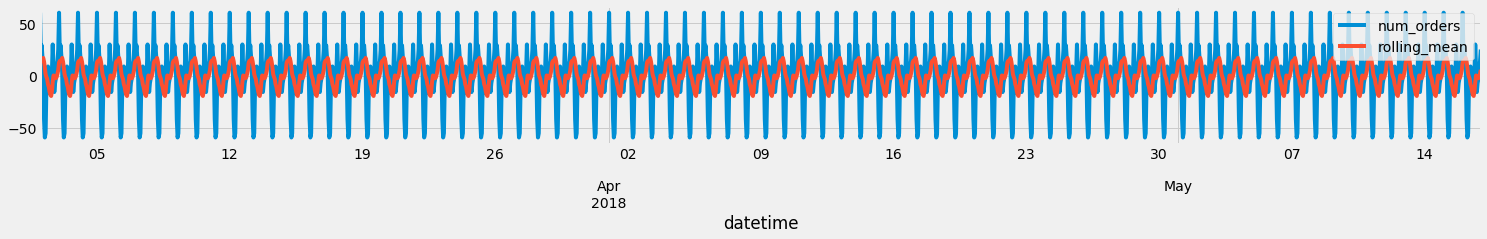

In [5]:
decomposed = seasonal_decompose(taxi_per_hour)

plt.figure(figsize=(23, 8))
plt.subplot(311)
decomposed.seasonal['2018-03-02':'2018-05-16'].plot(ax=plt.gca())

Представим отрезок данных, разбитых на компоненты на одном графике.

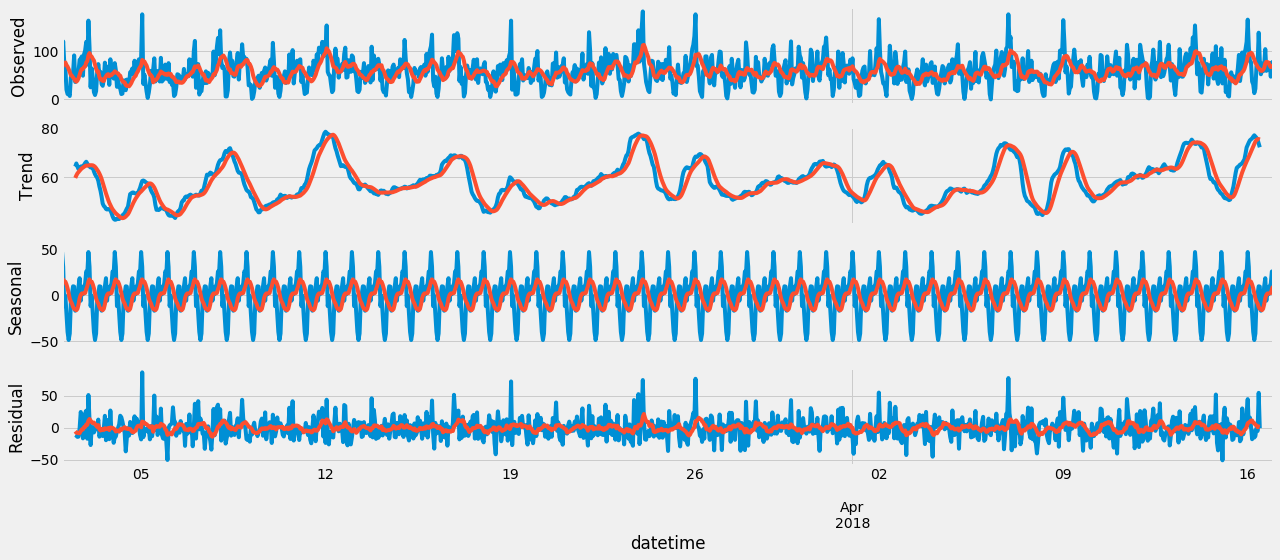

In [6]:
decomposition = sm.tsa.seasonal_decompose(taxi_per_hour['2018-03-02':'2018-04-16'], model='additive')
fig = decomposition.plot()
plt.show()

__Вывод__
При разделении на сезонные компоненты отчетливо видна суточная сезонность при распределении заказов такси, где пик приходится на 00 часов. 
Вероятно, это связано с тем, что поздно вечером часто прилетают самолеты, но уехать на общественном транспорте становится сложнее (в СПб к этому времени закрывается метро).
Возможно - с учетом того, что данные были взяты из одного аэропорта - в 00 часов прилетает больше всего рейсов, а в 06 часов прибывающих рейсов либо нет совсем, либо очень мало.

также мы можем сделать вывод, что ряд является стационарным, так как среднее и стандартное отклонение ряда не менятемя.

__Проверка ряда на стационарность__

Для проверки проверки стационарности проведем обобщенный тест Дикки-Фуллера на наличие единичных корней. Для этого в модуле statsmodels есть функция adfuller()

adf:  -3.0785919539634024
p-value:  0.02817858174083252
Critical values:  {'1%': -3.4318452331058706, '5%': -2.862200710612707, '10%': -2.567121700619383}

 Вывод

Единичных корней нет, ряд стационарен
Критерий Дики-Фуллера: p=0.028179


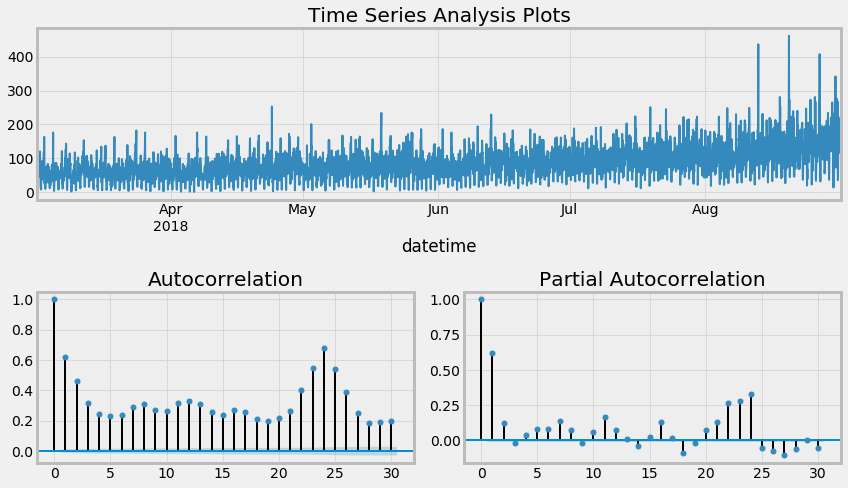

In [7]:
test = sm.tsa.adfuller(taxi_per_hour['num_orders'])
print( 'adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
print('\n Вывод\n')
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')
    
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(taxi_per_hour.num_orders, lags=30)

__Вывод__
Исходя из результатов, можем сделать вывод ,что ряд стационарен.

            num_orders
datetime              
2018-03-31    9.580645
2018-04-30   10.634028
2018-05-31   12.280466
2018-06-30   13.867130
2018-07-31   16.667787


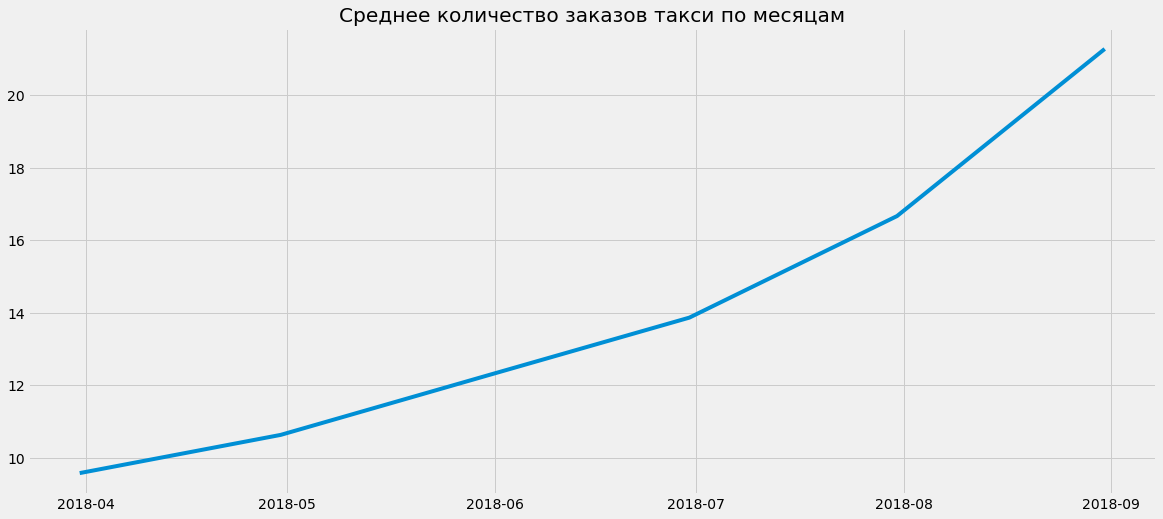

In [8]:
taxi_per_month= taxi.resample('1M',how='mean')
print(taxi_per_month.head())
plt.plot(taxi_per_month)
plt.title('Среднее количество заказов такси по месяцам')
plt.show()

__2.3. Создание признаков__
<a id='4-bullet'></a>

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# 3. Обучение

__3.1. Линейная регрессия__
<a id='5-bullet'></a>

In [10]:
counter = 100
lag_best = 0
rmsize_best = 0
for i in range(2,200,10):
    for j in range(2,800,50):
        taxi_features = taxi_per_hour.copy()
        make_features(taxi_features,i,j)

        train, test = train_test_split(taxi_features, shuffle=False, test_size=0.1)
        train.dropna(inplace=True)

        X_train = train.drop(columns=['num_orders'])
        y_train = train['num_orders']
        X_test = test.drop(columns=['num_orders'])
        y_test = test['num_orders']

        X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,shuffle=False, test_size=0.5)


        lr = LinearRegression()
        lr.fit(X_train, y_train)
        prediction = lr.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(prediction, y_valid))
        if rmse < counter:
            counter=rmse
            lag_best = i
            rmsizebest=j
            print(counter, 'lag=',i,'rmsize=',j)
print(taxi_per_hour)

49.463809163989865 lag= 2 rmsize= 2
49.40164881579253 lag= 2 rmsize= 252
49.382211412557965 lag= 2 rmsize= 352
49.37747226170233 lag= 2 rmsize= 502
49.044552130785156 lag= 2 rmsize= 552
49.00527062510917 lag= 2 rmsize= 602
48.98425402081139 lag= 2 rmsize= 652
48.902296231682485 lag= 2 rmsize= 702
48.88829181057679 lag= 2 rmsize= 752
48.66142367884976 lag= 12 rmsize= 52
48.56674671911288 lag= 12 rmsize= 652
48.38550826139305 lag= 12 rmsize= 702
48.35592998865374 lag= 12 rmsize= 752
46.54912983036956 lag= 22 rmsize= 2
45.451585601330194 lag= 22 rmsize= 52
45.231122294404244 lag= 22 rmsize= 702
45.18837140096354 lag= 22 rmsize= 752
44.578635288600566 lag= 32 rmsize= 52
44.42975659049263 lag= 32 rmsize= 652
44.17322823601698 lag= 32 rmsize= 702
44.07877334162717 lag= 32 rmsize= 752
42.84479534449951 lag= 42 rmsize= 52
41.55538824049208 lag= 52 rmsize= 2
41.555388240492036 lag= 52 rmsize= 52
41.46804972177101 lag= 52 rmsize= 202
41.46761918715778 lag= 52 rmsize= 452
41.31209169788605 lag= 5

__Вопрос__

Идея была в том, чтобы каждый раз заново присваивать признаки исходных данным, и сравнивать RMSE на новых признаках.
Проверка теперь на валидационной выборке.
Не могу понять, почему уменьшается тестовая выборка, она же делится каждый раз в одних и тех же пропорциях в одном порядке.

In [11]:
make_features(taxi_per_hour,lag_best,rmsizebest)
train, test = train_test_split(taxi_per_hour, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,shuffle=False, test_size=0.5)

__3.2. XGBRegressor__

In [12]:
tscv = TimeSeriesSplit(n_splits=2)

model = xgb.XGBRegressor()
param_search = {'splitter':('best','random'), 
              'max_depth':np.arange(1,5), 
              'min_samples_split':np.arange(2,6), 
              'min_samples_leaf':np.arange(1,4)}

my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=4).split(X_train)]
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search)
gsearch.fit(X_train, y_train)

[20:10:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3

__RandomForestRegressor при TimeSeriesSplit__

In [47]:
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# from sklearn.metrics import make_scorer
# def rmse(actual, predict):
#     predict = np.array(predict)
#     actual = np.array(actual)
#     distance = predict - actual
#     square_distance = distance ** 2
#     mean_square_distance = square_distance.mean()
#     score = np.sqrt(mean_square_distance)
#     return score
rmse_score = make_scorer(rmse, greater_is_better = False)


model = RandomForestRegressor()
param_search = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,10)]
}
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

# 4. Тестирование

__4.1. Проверка линейной регрессии на тестовых данных__
<a id='6-bullet'></a>

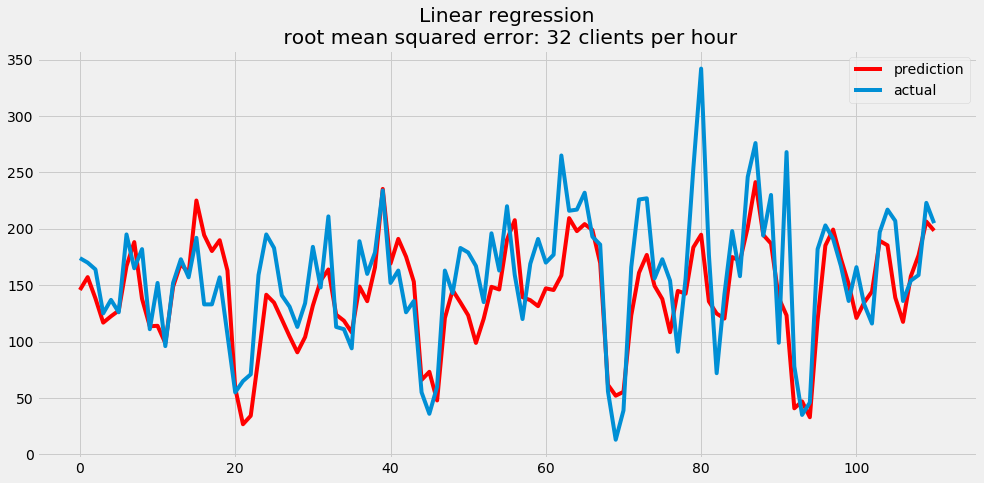

In [48]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(prediction, y_test))
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n root mean squared error: {} clients per hour".format(round(counter)))
plt.grid(True)

__Тестирование XGBRegressor__

In [49]:
print('Best score: ', gsearch.best_score_)
print('Best params: ', gsearch.best_params_)

best = gsearch.best_estimator_
print('RMSE: ', np.sqrt(mean_squared_error(y_pred = best.predict(X_test), y_true = y_test)))

Best score:  -25.043572257457786
Best params:  {'max_depth': 5, 'max_features': 'auto'}
RMSE:  43.52413851097994


__Вывод__
Значение RMSE достигает 39.5. Выше ,чем на линейной регрессии.

In [50]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
print('RMSE: ', round(np.sqrt(mean_squared_error(y_true, y_pred) ),4))

RMSE:  43.5241


Общий вывод
---
Лучший результат даёт линейная регрессия: на валидационной выборке она достигает значения RMSE 32, как и на тестовых.
